# O problema do caixeiro viajante

O problema do caixeiro viajante (ou Traveling Salesman Problem, em inglês) é um dos problemas clássicos mais importantes da pesquisa operacional.

## O enunciado básico do problema

Imagine que um caixeiro viajante (ou vendedor) precisa visitar um conjunto de cidades, partindo de uma delas, passando exatamente uma vez por cada cidade e retornando ao ponto de partida.

Cada cidade é ligada às outras por uma estrada com um custo, distância ou tempo de viagem.

O objetivo é encontrar o menor percurso possível que:

1. Passe por todas as cidades exatamente uma vez;

2. E retorne à cidade inicial.

## Representação matemática

O TSP pode ser representado como um grafo completo ponderado:

- As cidades são os nós (vértices do grafo).

- As distâncias entre as cidades são as arestas com pesos $d_{ij}$

O problema é então encontrar o circuito Hamiltoniano de menor custo - ou seja, um ciclo que visita todos os vértices uma única vez e volta ao início, minimizando o custo total.

## Formulação matemática

$min \sum \limits _{i=1}^{n}\sum \limits _{j=1}^{n} d_{ij}x_{ij}$

Sujeito a:

1. $\sum \limits _{j=1}^{n} x_{ij} = 1$ para todo $i$ -> cada cidade é deixada

2. $\sum \limits _{i=1}^{n} x_{ij} = 1$ para todo $j$ -> cada cidade é chegada uma vez

3. Subconjuntos $S$ de cidades devem satisfazer:

$\sum \limits _{i \in S} \sum \limits _{j \in S} x_{ij}  <= |S| - 1$ -> para evitar subciclos

4. $x_{ij} \in {0,1}$, indicando se o caminho de $i$ para $j$ é usado

Figura 9.11 do livro **Pesquisa Operacional de Hamdy A. Taha**

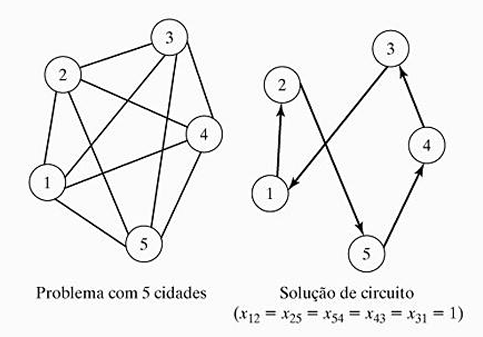

## Problema que quero resolver

Coleciono discos de vinil e gostaria de fazer uma viagem a São Paulo para conhecer algumas lojas de discos. Como não tenho nenhuma em específico em mente, pedi ao ChatGPT para gerar uma base com algumas lojas e suas informações.

Com isso, decidi aplicar o problema do caixeiro viajante para obter o caminho com a menor distância que se inicia no hotel, passa por todas as lojas e, no fim, volta ao hotel.

Logo, aqui, o peso é a distância.

## Resolvendo com programação linear inteira mista (MILP)

### Importando as bibliotecas

In [1]:
import pandas as pd
from geopy import distance
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pulp

### Carregando a base de dados

Essa base de dados foi gerada pelo ChatGPT e tratada minimamente no arquivo *data_clean.ipynb*.

Nesta base, existem 10 registros de lojas de discos de vinil e 1 registro referente ao hotel.

In [2]:
df = pd.read_csv('./data/data_t.csv')
df

,nome,endereço,cep,tipo,destaque,ideal_para,nota,latitude,longitude
0,EZ Aclimação,"Av. Armando Ferrentini, 668 - Aclimação, São P...",04103-030,Hotel,Hotel,Hotel,NaN,-23.577447,-46.636796
1,Casarão do Vinil,"Rua dos Trilhos, 1212 - Mooca, São Paulo - SP",03168-009,Loja especializada,Maior acervo da América Latina,Garimpar raridades,4.5,-23.553817,-46.597823
2,Eric Discos,"R. Artur de Azevedo, 1874 - Pinheiros, São Pau...",05404-005,Loja especializada,Loja tradicional com grande acervo,"Rock, MPB, jazz, colecionadores",4.6,-23.566632,-46.688553
3,Baratos Afins,"R. 24 de Maio, 62 - Galeria do Rock, São Paulo...",01041-000,Loja / Sebo,Ícone da cena independente e rock,Rock e música independente,4.5,-23.543874,-46.639969
4,Supernova Discos (Galeria do Rock),"R. 24 de Maio, 62 - loja 279 - Galeria do Rock...",01041-000,Loja,Vasto catálogo de LPs novos e usados,Garimpo no centro,NaN,-23.543874,-46.639969
5,The Scream Discos,"Av. São João, 439 - Galeria do Rock, loja 462,...",01010-000,Loja,Foco em rock e alternativo,Fãs de rock,NaN,-23.547663,-46.635972
6,Patuá Discos,"R. Fidalga, 516 - Vila Madalena, São Paulo - SP",05436-010,Loja especializada,Vinhos e discos independentes (curadoria),"Música independente, novidades",NaN,-23.555218,-46.690625
7,London Calling Discos,Galeria do Rock (Av. São João / Rua 24 de Maio...,01010-000,Loja,Loja com foco em rock e colecionáveis,"Rock, colecionadores",NaN,-23.547663,-46.635972
8,Sebo do Messias,"Rua Quintino Bocaiúva, 285 - Sé, São Paulo - SP",01013-010,Sebo,"Preços baixos, ótimo para garimpar",Achados e pechinchas,NaN,-23.551160,-46.635368
9,Museu do Disco,"Rua Quintino Bocaiúva, 274 - Sé, São Paulo - SP",01013-000,Museu / Sebo,Acervo histórico de discos,"Curiosidade, pesquisa histórica",NaN,-23.550997,-46.635515


### Gerando uma matriz quadrada

Os valores se referem às distâncias em km entre os locais presentes na base de dados, levando em conta suas latitudes e longitudes

In [3]:
def func(row1, row2):
    return distance.distance((row1['latitude'], row1['longitude']), (row2['latitude'], row2['longitude'])).km

stores = df['nome']
matrix = pd.DataFrame(
    index=stores,
    columns=stores,
    dtype=float
)
for i, row_i in df.iterrows():
    for j, row_j in df.iterrows():
        result = func(row_i, row_j)
        matrix.loc[row_i['nome'], row_j['nome']] = result

matrix

nome,EZ Aclimação,Casarão do Vinil,Eric Discos,Baratos Afins,Supernova Discos (Galeria do Rock),The Scream Discos,Patuá Discos,London Calling Discos,Sebo do Messias,Museu do Disco,Galeria Nova Barão (conjunto de lojas)
nome,,,,,,,,,,,
EZ Aclimação,0.000000,4.762319,5.417639,3.732347,3.732347,3.299664,6.021647,3.299664,2.914976,2.932330,3.467176
Casarão do Vinil,4.762319,0.000000,9.371058,4.441885,4.441885,3.954234,9.476260,3.954234,3.844589,3.861018,4.468957
Eric Discos,5.417639,9.371058,0.000000,5.563910,5.563910,5.764709,1.281637,5.764709,5.693872,5.685008,5.363661
Baratos Afins,3.732347,4.441885,5.563910,0.000000,0.000000,0.585392,5.322554,0.585392,0.933741,0.910547,0.289721
Supernova Discos (Galeria do Rock),3.732347,4.441885,5.563910,0.000000,0.000000,0.585392,5.322554,0.585392,0.933741,0.910547,0.289721
The Scream Discos,3.299664,3.954234,5.764709,0.585392,0.585392,0.000000,5.642549,0.000000,0.392150,0.372116,0.517414
Patuá Discos,6.021647,9.476260,1.281637,5.322554,5.322554,5.642549,0.000000,5.642549,5.659666,5.646136,5.176941
London Calling Discos,3.299664,3.954234,5.764709,0.585392,0.585392,0.000000,5.642549,0.000000,0.392150,0.372116,0.517414
Sebo do Messias,2.914976,3.844589,5.693872,0.933741,0.933741,0.392150,5.659666,0.392150,0.000000,0.023529,0.770905


### Criando funções

Algumas funções foram criadas aqui:

- A que gera o grafo

- A que plota esse grafo criado

- A que calcula o custo do caminho resultante (aqui, com base nas distâncias entre os locais)

In [ ]:
def generate_graph( df, df_o ):
    N = df.shape[0]

    G = nx.Graph()
    for i in range( 0, N ):
        G.add_node( i, pos = ( df_o.iloc[i, 7], df_o.iloc[i, 8] ) ) #latitude e longitude para a posição do nó no grafo

    for i in range( 0, N ):
        for j in range( i + 1, N ):
            G.add_edge( i, j, weight = df.iloc[i, j] ) #distância entre cada nó como os pesos

    return G

def plot_graph( G, edgelist = None, paths = [], source = None, legend = None ):

    pos = nx.get_node_attributes( G, 'pos' )

    plt.figure( figsize = ( 9, 9 ) )

    nx.draw_networkx_nodes( G, pos, node_size = 15 )
    if not ( source is None ):
        plt.scatter( pos[ source ][ 0 ], pos[ source ][ 1 ], s = 30, c = 'r', zorder = 10 )
    nx.draw_networkx_edges( G, pos, edgelist = edgelist, width = 0.2 )

    colors = plt.rcParams[ 'axes.prop_cycle' ].by_key()[ 'color' ]
    lines = []
    for i in range( len( paths ) ):
        p = paths[ i ]
        c = colors[ i + 1 ]
        lines.append( nx.draw_networkx_edges( G, pos, edgelist = p, width = 3, edge_color = c ) )

    # edge_labels = {(u, v): f"{d['weight']} km" for u, v, d in G.edges(data=True)}
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    

    if not ( legend is None ):
        plt.legend( lines[ : len( legend ) ], legend )

    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    plt.margins( 0.1 )
    plt.axis( 'off' )
    plt.show()

def path_cost( G, P ):

    c = 0.0
    for e in P:
        c += G.get_edge_data( *e )[ 'weight' ]
    
    return c


### Gerando e plotando o grafo de acordo com os dados

O ponto inicial é o 0, ou seja, o registro 0 da matriz

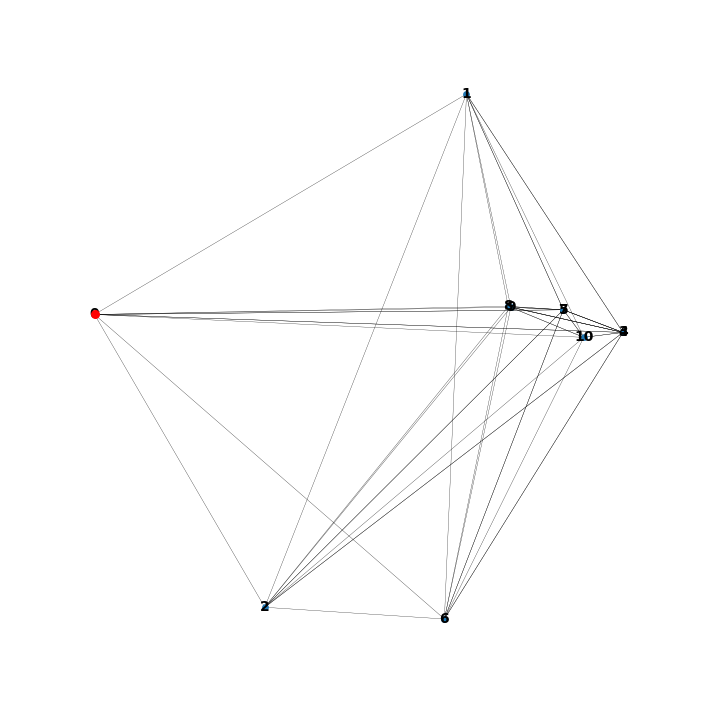

Graph with 11 nodes and 55 edges


In [5]:
G = generate_graph( matrix, df )

plot_graph( G , source=0)

print( G )

### Criando a função que resolve o problema

Aqui, uso a biblioteca PuLP com o solucionador CBC.

In [6]:
def tsp( G, solver = pulp.PULP_CBC_CMD( msg = False ) ):

    # Conjunto de vértices
    V = set( G.nodes )

    # Variáveis:
    x = {}
    for i, j in G.edges:
        if i != j:
            x[ i, j ]= pulp.LpVariable(
                name = f'x_({i},{j})', cat = pulp.LpBinary
            )
            x[ j, i ]= pulp.LpVariable(
                name = f'x_({j},{i})', cat = pulp.LpBinary
            )

    # Modelo
    p = pulp.LpProblem( name = 'Caixeiro_viajante', sense = pulp.LpMinimize )

    # Função objetivo
    p += pulp.lpSum(
            G.get_edge_data( *ij )[ 'weight' ] * x[ ij ] for ij in x
        )

    # Restrições de saída
    for i in V:
        p += ( pulp.lpSum( x[ i, j ] for j in V - { i } ) == 1 )

    # Restrições de entrada
    for j in V:
        p += ( pulp.lpSum( x[ i, j ] for i in V - { j } ) == 1 )

    # Restrições de ciclo
    i_out = list( G.nodes )[ -1 ]
    y = {}
    for i in V - { i_out }:
        y[ i ] = pulp.LpVariable( name = f'y({i})', cat = pulp.LpContinuous )

    for i, j in x:
        if ( i != i_out ) and ( j != i_out ):
            p += ( y[ i ] >= y[ j ] + x[ i, j ] - len( V ) * ( 1 - x[ i, j ] ) )

    # Resolve o problema
    p.solve(
        solver
    )

    print( 'Solution status: ' + pulp.LpSolution[ p.sol_status ] )
    print( 'Solver status  : ' + pulp.LpStatus[ p.status ] )

    elist = []
    for ij in x:
        if x[ ij ].value() > 1e-6:
            elist.append( ij )

    print( 'Cost          :', path_cost( G, elist ) )

    return elist

### Resolvendo o problema com base no grafo e plotando o grafo com o caminho resultante

Solution status: Optimal Solution Found
Solver status  : Optimal
Cost          : 21.753882287409894


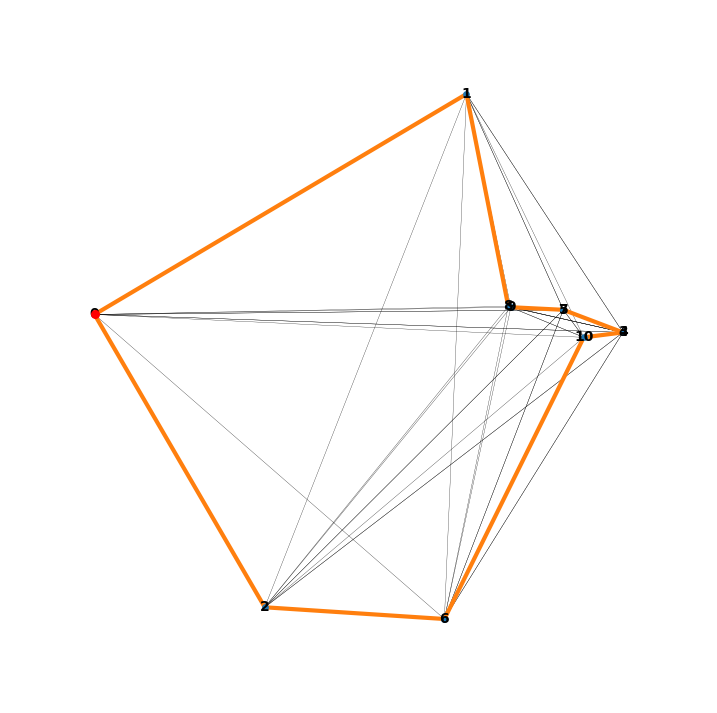

In [7]:
elist = tsp( G )
plot_graph( G, paths = [ elist ], source=0 )

### Imprimindo a ordem do caminho

In [8]:
elist

[(1, 0),
 (0, 2),
 (8, 1),
 (2, 6),
 (4, 3),
 (3, 7),
 (10, 4),
 (7, 5),
 (5, 9),
 (6, 10),
 (9, 8)]

Ou seja, o caminho resultante (os números se referem ao número da linha na matriz):

0 -> 2 -> 6 -> 10 -> 4 -> 3 -> 7 -> 5 -> 9 -> 8 -> 1 -> 0

Em termos dos nomes dos locais

EZ Aclimação (Hotel) -> Eric Discos -> Patuá Discos -> Galeria Nova Barão (conjunto de lojas) -> Supernova Discos (Galeria do Rock) -> Baratos Afins -> London Calling Discos -> The Scream Discos -> Museu do Disco -> Sebo do Messias -> Casarão do Vinil -> EZ Aclimação (Hotel)